<div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;">
<div style="font-size:36px;font-weight:700;">DHARMA</div>
<div style="font-size:16px;font-weight:500;opacity:0.75;">Distributed Hybrid Architecture for Responsible Model Alignment and Assured Privacy</div>
</div>

# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Project Overview</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

This notebook establishes the **baseline foundation** for the DHARMA framework by training and evaluating a Hybrid Vertical Federated Learning (VFL) system on the HAM10000 skin lesion dataset. This foundation notebook prepares all necessary components including trained models, computed embeddings, and baseline performance metrics, that will be used in subsequent [**INTEGRITY**](https://www.kaggle.com/code/mostafaanoosha/dharma-02-integrity-audit) and [**PRIVACY**](https://www.kaggle.com/code/mostafaanoosha/dharma-03-privacy-audit) audit notebooks.

The DHARMA architecture implements a **Hybrid Vertical Federated Learning** system that mirrors real-world clinical workflows. The system consists of two distinct, privacy-preserving clients:

* **Image Client:** Represents edge hardware such as a **Digital Dermatoscope** or **optical scanner** that captures dermoscopic images directly from patients. In real-world scenarios, this sensor is vulnerable to physical defects (lens scratches), environmental noise (sensor calibration errors), and adversarial perturbations.
* **Tabular Client:** Represents the hospital's Electronic Health Record (EHR) system, holding secure metadata including Age, Sex, and Anatomical Site.

In VFL, these clients do not share raw data; instead, they exchange feature embeddings which are mathematically rich representations that contain highly condensed information. The central server aggregates these embeddings using cross-modal attention mechanisms to make final predictions. The HAM10000 dataset presents a significant challenge due to extreme class imbalance, where common conditions like Melanocytic nevi (`nv`) vastly outnumber rare but critical cases like Melanoma (`mel`). This notebook demonstrates how the Hybrid VFL framework addresses this imbalance through cross-modal attention and alignment regularization, establishing a robust baseline for subsequent adversarial stress testing.

# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Setup and Data Handling</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Importing Libraries**
Any successful experimental notebook relies on a clear understanding of the tools and libraries used. In this subsection, we import all required Python libraries for data handling, model construction, training, evaluation, and visualization. These libraries form the foundation of the DHARMA experimental pipeline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Concatenate, Dense, Dropout, 
                                     LayerNormalization, MultiHeadAttention, 
                                     Reshape, Flatten, Conv2D, Conv2DTranspose,
                                     BatchNormalization, LeakyReLU)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pickle
import time
import warnings
import os
from IPython.display import HTML, display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')
print("Imports loaded successfully")

2025-12-24 17:54:52.716610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766598892.953054      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766598893.018304      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766598893.555605      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766598893.555655      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766598893.555658      17 computation_placer.cc:177] computation placer alr

Imports loaded successfully


<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Configuring Caching System**
As the DHARMA framework employs deep neural networks to extract dual embeddings from multiple clients, a full training cycle can take several hours. To enable efficient experimentation, we implement a caching mechanism that:

1. **Loads previously trained models** when available from input datasets or working directory
2. **Restores precomputed embeddings** from disk to avoid redundant computation
3. **Preserves training history** and performance metrics for reproducibility

This caching strategy allows the framework to operate both as a full training environment and as a lightweight evaluation platform when cached assets are available, significantly reducing execution time for iterative experimentation.

In [2]:
ENABLE_CACHING = True
INPUT_DATASET_DIR = '/kaggle/input/hybridvfl-exp-4/'
WORKING_DIR = '/kaggle/working/'
CACHE_DIR = '/kaggle/working/cache/'

# Asset names
ASSET_NAMES = {
    'dual_image_client': 'exp4_dual_image_client.keras',
    'dual_tabular_client': 'exp4_dual_tabular_client.keras',
    'transformer_server': 'exp4_transformer_server.keras',
    'training_history': 'cache/training_history.pkl',
    'train_embeddings': 'cache/train_embeddings.npz',
    'test_embeddings': 'cache/test_embeddings.npz',
    'final_results': 'exp4_results.pkl',
}

os.makedirs(CACHE_DIR, exist_ok=True)
print("Cache configuration initialized")

Cache configuration initialized


In [3]:
def find_asset(asset_name):
    """Find asset in input dataset first, then working dir. Returns path or None."""
    # Check input dataset (uploaded pre-trained)
    input_path = INPUT_DATASET_DIR + ASSET_NAMES[asset_name]
    if os.path.isfile(input_path):
        return input_path
    
    # Check working directory (current session)
    if asset_name in ['training_history', 'train_embeddings', 'test_embeddings']:
        working_path = CACHE_DIR + ASSET_NAMES[asset_name].replace('cache/', '')
    else:
        working_path = WORKING_DIR + ASSET_NAMES[asset_name]
    
    if os.path.isfile(working_path):
        return working_path
    
    return None

def get_save_path(asset_name):
    """Get path for saving asset (always to working dir)."""
    if asset_name in ['training_history', 'train_embeddings', 'test_embeddings']:
        return CACHE_DIR + ASSET_NAMES[asset_name].replace('cache/', '')
    else:
        return WORKING_DIR + ASSET_NAMES[asset_name]

def all_models_exist():
    return all([
        find_asset('dual_image_client') is not None,
        find_asset('dual_tabular_client') is not None,
        find_asset('transformer_server') is not None
    ])

def check_training_completed():
    return all_models_exist() and find_asset('final_results') is not None

def embeddings_cached():
    return (find_asset('test_embeddings') is not None and
            find_asset('train_embeddings') is not None)

def print_checkpoint_status():
    print("Asset status (Input → Working):")
    # Find the maximum length of asset names for alignment
    max_name_length = max(len(name) for name in ASSET_NAMES.keys())
    
    for name in ASSET_NAMES.keys():
        path = find_asset(name)
        if path:
            location = "INPUT" if INPUT_DATASET_DIR in path else "WORKING"
            # Pad the asset name to align "FOUND in" messages
            padded_name = name.ljust(max_name_length)
            print(f"  {padded_name}: FOUND in {location}")
        else:
            padded_name = name.ljust(max_name_length)
            print(f"  {padded_name}: MISSING")

print("Utility functions defined")

Utility functions defined


In [4]:
FORCE_RETRAIN = False
FORCE_RECOMPUTE_EMBEDDINGS = False
CLEAR_ALL_CACHE = False

if CLEAR_ALL_CACHE:
    import shutil
    if os.path.exists(CACHE_DIR):
        shutil.rmtree(CACHE_DIR)
    os.makedirs(CACHE_DIR, exist_ok=True)
    for asset in ['dual_image_client', 'dual_tabular_client', 'transformer_server', 'final_results']:
        path = get_save_path(asset)
        if os.path.exists(path):
            os.remove(path)
    print("All cache cleared")
else:
    print("Cache control initialized")
    print_checkpoint_status()

Cache control initialized
Asset status (Input → Working):
  dual_image_client  : FOUND in INPUT
  dual_tabular_client: FOUND in INPUT
  transformer_server : FOUND in INPUT
  training_history   : FOUND in INPUT
  train_embeddings   : FOUND in INPUT
  test_embeddings    : FOUND in INPUT
  final_results      : FOUND in INPUT


<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Loading Data**
The HAM10000 dataset consists of dermoscopic skin lesion images and associated metadata. In this subsection, we load preprocessed data from previous experiments, including:

* **Training and test images** (`X_train`, `X_test`) with corresponding labels (`y_train`, `y_test`)
* **Tabular features** extracted from metadata (age, sex, anatomical site) for both training and test sets
* **Class weight dictionary** to handle class imbalance during training
* **Pre-trained base image model** from previous experiments to extract feature representations

This data loading ensures consistent alignment between image and tabular modalities, which is essential for the Hybrid VFL training pipeline.

In [5]:
BASE_PATH_EXP1 = '/kaggle/input/hybridvfl-exp-1/'
BASE_PATH_EXP2 = '/kaggle/input/hybridvfl-exp-2/'
BASE_PATH_EXP3 = '/kaggle/input/hybridvfl-exp-3/'

image_model = load_model(BASE_PATH_EXP1 + 'best_image_model.keras')

X_train = np.load(BASE_PATH_EXP1 + 'X_train.npy')
X_test = np.load(BASE_PATH_EXP1 + 'X_test.npy')
y_train = np.load(BASE_PATH_EXP1 + 'y_train.npy')
y_test = np.load(BASE_PATH_EXP1 + 'y_test.npy')

train_tabular_features = np.load(BASE_PATH_EXP2 + 'train_tabular_features.npy')
test_tabular_features = np.load(BASE_PATH_EXP2 + 'test_tabular_features.npy')

with open(BASE_PATH_EXP1 + 'class_weight_dict.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

with open(BASE_PATH_EXP2 + 'exp1_2_results.pkl', 'rb') as f:
    prev_results = pickle.load(f)

with open(BASE_PATH_EXP3 + 'exp3_results.pkl', 'rb') as f:
    exp3_results = pickle.load(f)

total_data_mb = (X_train.nbytes + X_test.nbytes + train_tabular_features.nbytes + test_tabular_features.nbytes) / (1024**2)
print(f"Data loaded to RAM: {X_train.shape[0]} train, {X_test.shape[0]} test samples ({total_data_mb:.1f} MB)")

2025-12-24 17:55:10.227855: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Data loaded to RAM: 21252 train, 5313 test samples (763.9 MB)


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Model Architecture</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Model Design**
The DHARMA framework implements a **Hybrid Vertical Federated Learning** architecture with a disentangled representation learning approach. The system consists of three interconnected components:

**Dual Image Client:**
* Processes raw dermoscopic images through a pre-trained convolutional backbone
* Produces **image-specific embeddings** (`spec_img`): Capture visual features unique to dermoscopic images, such as lesion texture, color patterns, and morphological characteristics
* Produces **image-invariant embeddings** (`inv_img`): Capture cross-modal shared information that can be aligned with tabular representations

**Dual Tabular Client:**
* Processes structured metadata (age, sex, anatomical site) through dense layers
* Produces **tabular-specific embeddings** (`spec_tab`): Capture demographic and clinical metadata features specific to tabular data
* Produces **tabular-invariant embeddings** (`inv_tab`): Capture shared semantic information that aligns with image representations

**Cross-Modal Transformer Server:**
* Receives all four embedding types from both clients
* Uses **multi-head attention** to fuse image-specific and tabular-specific embeddings, enabling cross-modal information exchange
* Combines attended features with invariant embeddings from both modalities
* Performs final classification through dense layers with dropout regularization

The disentangled design enables the model to leverage both modality-specific information and cross-modal shared patterns, while the alignment regularization encourages invariant embeddings from different modalities to converge, facilitating robust multimodal learning.

The following illustration shows the complete model design and data flow:
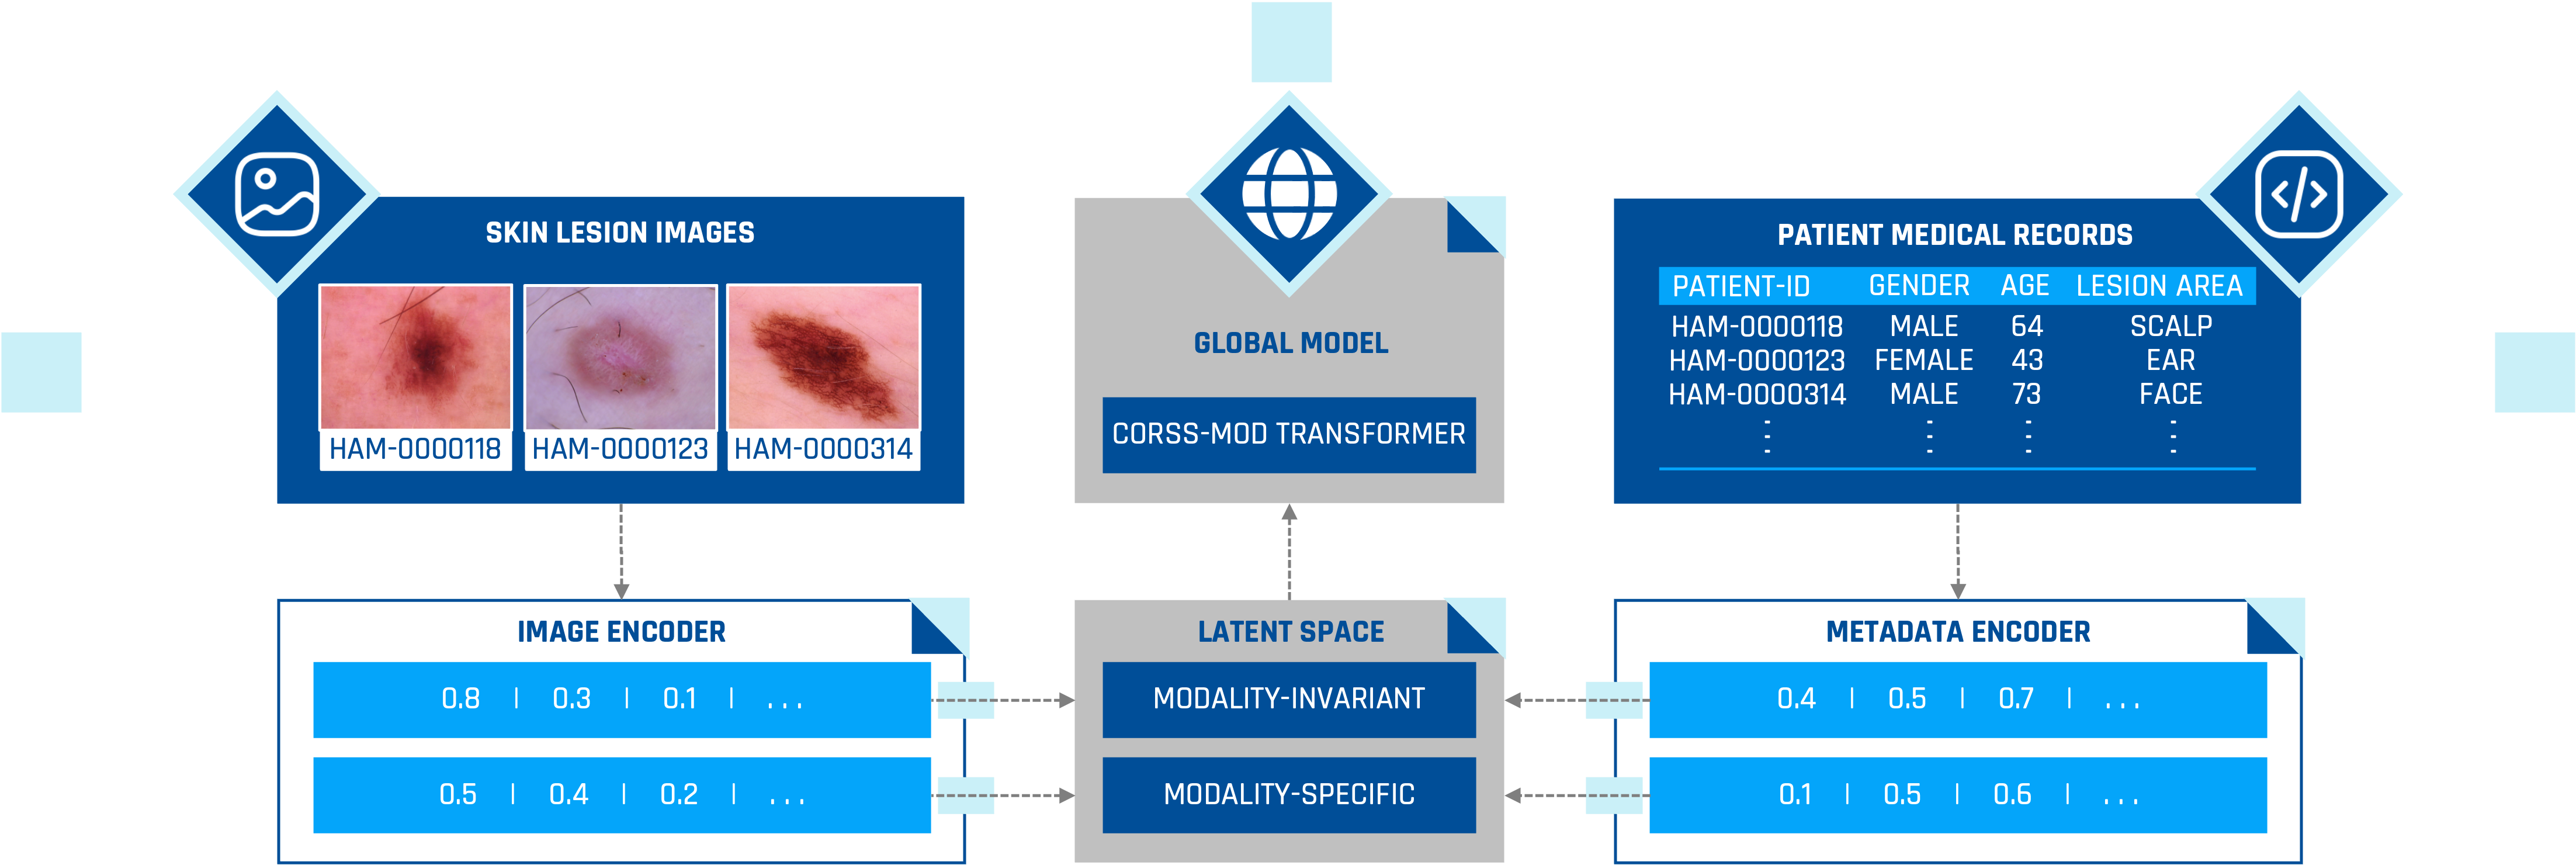

In [6]:
# Check if trained models exist
if ENABLE_CACHING and all_models_exist() and not FORCE_RETRAIN:
    img_path = find_asset('dual_image_client')
    tab_path = find_asset('dual_tabular_client')
    server_path = find_asset('transformer_server')
    
    print(f"Loading pre-trained models from {'INPUT' if INPUT_DATASET_DIR in img_path else 'WORKING'}")
    dual_image_client = load_model(img_path)
    dual_tabular_client = load_model(tab_path)
    transformer_server = load_model(server_path)
    
    optimizer_img = Adam(learning_rate=0.0001)
    optimizer_tab = Adam(learning_rate=0.0001)
    optimizer_server = Adam(learning_rate=0.0001)
    
    print("Models loaded successfully")
else:
    print("Building models from scratch")
    
    # Base image model extraction
    if hasattr(image_model, 'input') and image_model.input is not None:
        model_input = image_model.input
    else:
        model_input = image_model.layers[0].input

    feature_layer = None
    for layer in image_model.layers:
        if isinstance(layer, tf.keras.layers.MaxPooling2D):
            feature_layer = layer
            if 'max_pooling2d_2' in layer.name:
                break

    if feature_layer is None or 'max_pooling2d_2' not in feature_layer.name:
        maxpool_layers = [layer for layer in image_model.layers if isinstance(layer, tf.keras.layers.MaxPooling2D)]
        if len(maxpool_layers) >= 2:
            feature_layer = maxpool_layers[1]
        else:
            feature_layer = maxpool_layers[0]

    base_image_model = Model(
        inputs=model_input,
        outputs=feature_layer.output,
        name='ImageBase'
    )

    for layer in base_image_model.layers:
        layer.trainable = False

    # Dual Image Client
    image_input = Input(shape=(100, 100, 3), name='image_input')
    base_features = base_image_model(image_input)
    base_flat = Flatten(name='image_flatten')(base_features)

    specific_img = Dense(2048, activation='relu', name='img_specific_dense1')(base_flat)
    specific_img = Dropout(0.3, name='img_specific_dropout1')(specific_img)
    specific_img_output = Dense(1024, activation='relu', name='img_specific_output')(specific_img)

    invariant_img = Dense(512, activation='relu', name='img_invariant_dense1')(base_flat)
    invariant_img = Dropout(0.2, name='img_invariant_dropout1')(invariant_img)
    invariant_img_output = Dense(256, activation='relu', name='img_invariant_output')(invariant_img)

    dual_image_client = Model(
        inputs=image_input,
        outputs=[specific_img_output, invariant_img_output],
        name='DualImageClient'
    )

    # Dual Tabular Client
    tabular_input = Input(shape=(train_tabular_features.shape[1],), name='tabular_input')

    specific_tab = Dense(128, activation='relu', name='tab_specific_dense1')(tabular_input)
    specific_tab = Dropout(0.3, name='tab_specific_dropout1')(specific_tab)
    specific_tab_output = Dense(64, activation='relu', name='tab_specific_output')(specific_tab)

    invariant_tab = Dense(128, activation='relu', name='tab_invariant_dense1')(tabular_input)
    invariant_tab = Dropout(0.2, name='tab_invariant_dropout1')(invariant_tab)
    invariant_tab_output = Dense(256, activation='relu', name='tab_invariant_output')(invariant_tab)

    dual_tabular_client = Model(
        inputs=tabular_input,
        outputs=[specific_tab_output, invariant_tab_output],
        name='DualTabularClient'
    )

    # Transformer Server
    spec_img_input = Input(shape=(1024,), name='server_spec_img_input')
    inv_img_input = Input(shape=(256,), name='server_inv_img_input')
    spec_tab_input = Input(shape=(64,), name='server_spec_tab_input')
    inv_tab_input = Input(shape=(256,), name='server_inv_tab_input')

    spec_img_proj = Dense(128, activation='relu', name='spec_img_proj')(spec_img_input)
    spec_tab_proj = Dense(128, activation='relu', name='spec_tab_proj')(spec_tab_input)

    spec_img_seq = Reshape((1, 128), name='spec_img_seq')(spec_img_proj)
    spec_tab_seq = Reshape((1, 128), name='spec_tab_seq')(spec_tab_proj)

    feature_sequence = Concatenate(axis=1, name='feature_sequence')([spec_img_seq, spec_tab_seq])

    attention_layer = MultiHeadAttention(
        num_heads=4, 
        key_dim=32, 
        dropout=0.1,
        name='cross_modal_attention'
    )
    attended = attention_layer(feature_sequence, feature_sequence)

    attended = LayerNormalization(epsilon=1e-6, name='attention_layernorm')(attended)

    attended_flat = Flatten(name='attended_flatten')(attended)

    final_features = Concatenate(name='final_features')([
        attended_flat,
        inv_img_input,
        inv_tab_input
    ])

    x_server = Dense(4096, activation='relu', name='server_fc1')(final_features)
    x_server = Dropout(0.5, name='server_dropout1')(x_server)
    x_server = Dense(4096, activation='relu', name='server_fc2')(x_server)
    x_server = Dropout(0.5, name='server_dropout2')(x_server)
    server_output = Dense(7, activation='softmax', name='server_output')(x_server)

    transformer_server = Model(
        inputs=[spec_img_input, inv_img_input, spec_tab_input, inv_tab_input],
        outputs=server_output,
        name='TransformerServer'
    )

    optimizer_img = Adam(learning_rate=0.0001)
    optimizer_tab = Adam(learning_rate=0.0001)
    optimizer_server = Adam(learning_rate=0.0001)

    transformer_server.compile(
        optimizer=optimizer_server,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Models built successfully")

Loading pre-trained models from INPUT
Models loaded successfully


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Model Training</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Training Configuration and Process**
The Hybrid VFL training process uses a federated learning protocol where clients compute embeddings locally and share them with the central server. The training configuration includes:

* **Epochs:** Number of training iterations over the entire dataset
* **Batch size:** Number of samples processed in each training step
* **Alignment regularization:** `LAMBDA_ALIGNMENT` parameter controlling the strength of cross-modal alignment between image and tabular invariant embeddings

The training pipeline implements a federated learning protocol where:

1. **Clients compute embeddings:** Each client (image and tabular) processes its local data and produces specific and invariant embeddings
2. **Server aggregates embeddings:** The transformer server receives embeddings from all clients and uses multi-head attention to fuse cross-modal information
3. **Gradients flow back:** The server computes gradients and sends them back to clients, enabling distributed optimization without sharing raw data

This process is repeated for multiple epochs, with validation performed on the test set after each epoch to monitor generalization performance. The training minimizes a combined loss function consisting of classification loss (with class weights to handle imbalance) and alignment loss (to encourage invariant embeddings from different modalities to be similar).

In [7]:
VFL4_EPOCHS = 50
VFL4_BATCH_SIZE = 32
LAMBDA_ALIGNMENT = 0.5

num_train_samples = len(X_train)
num_batches = num_train_samples // VFL4_BATCH_SIZE

# Check if training already completed with correct number of epochs
skip_training = False
history_path = find_asset('training_history')
if ENABLE_CACHING and history_path is not None and not FORCE_RETRAIN:
    with open(history_path, 'rb') as f:
        history_data = pickle.load(f)
    
    # Check if saved epochs match requested epochs
    if len(history_data['train_loss']) == VFL4_EPOCHS:
        vfl4_train_loss_history = history_data['train_loss']
        vfl4_train_acc_history = history_data['train_acc']
        vfl4_val_loss_history = history_data['val_loss']
        vfl4_val_acc_history = history_data['val_acc']
        vfl4_class_loss_history = history_data['class_loss']
        vfl4_align_loss_history = history_data['align_loss']
        vfl4_comm_costs_upload = history_data['comm_upload']
        vfl4_comm_costs_download = history_data['comm_download']
        vfl4_total_time = history_data['total_time']
        skip_training = True
        location = 'INPUT' if INPUT_DATASET_DIR in history_path else 'WORKING'
        print(f"Training already completed for {VFL4_EPOCHS} epochs, loading from {location}")
    else:
        print(f"Found {len(history_data['train_loss'])} epochs, but {VFL4_EPOCHS} requested, retraining")

if not skip_training:
    print("Starting training with optimized data pipeline")
    vfl4_train_loss_history = []
    vfl4_train_acc_history = []
    vfl4_val_loss_history = []
    vfl4_val_acc_history = []
    vfl4_class_loss_history = []
    vfl4_align_loss_history = []
    vfl4_comm_costs_upload = []
    vfl4_comm_costs_download = []
    
    # Create optimized tf.data.Dataset pipeline
    train_dataset = tf.data.Dataset.from_tensor_slices((
        X_train,
        train_tabular_features,
        y_train
    ))
    train_dataset = train_dataset.shuffle(buffer_size=num_train_samples, seed=RANDOM_STATE)
    train_dataset = train_dataset.batch(VFL4_BATCH_SIZE, drop_remainder=False)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    
    print(f"Data pipeline created: {num_train_samples} samples, {num_batches} batches")

    vfl4_start_time = time.time()

    for epoch in range(VFL4_EPOCHS):
        epoch_start = time.time()
        epoch_loss = 0
        epoch_class_loss = 0
        epoch_align_loss = 0
        epoch_acc = 0
        epoch_upload_cost = 0
        epoch_download_cost = 0
        
        batch_count = 0
        for X_batch, X_tab_batch, y_batch in train_dataset:
            with tf.GradientTape(persistent=True) as client_tape:
                spec_img, inv_img = dual_image_client(X_batch, training=True)
                spec_tab, inv_tab = dual_tabular_client(X_tab_batch, training=True)
            
            upload_cost = (spec_img.numpy().nbytes + inv_img.numpy().nbytes + 
                           spec_tab.numpy().nbytes + inv_tab.numpy().nbytes) / (1024 * 1024)
            epoch_upload_cost += upload_cost
            
            with tf.GradientTape(persistent=True) as server_tape:
                predictions = transformer_server([spec_img, inv_img, spec_tab, inv_tab], training=True)
                
                sample_weights = np.array([class_weight_dict[np.argmax(y)] for y in y_batch])
                class_loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)
                class_loss = tf.reduce_mean(class_loss * sample_weights)
                
                alignment_loss = tf.reduce_mean(tf.square(inv_img - inv_tab))
                
                total_loss = class_loss + LAMBDA_ALIGNMENT * alignment_loss
            
            server_grads = server_tape.gradient(total_loss, transformer_server.trainable_variables)
            optimizer_server.apply_gradients(zip(server_grads, transformer_server.trainable_variables))
            
            grad_spec_img = server_tape.gradient(total_loss, spec_img)
            grad_inv_img = server_tape.gradient(total_loss, inv_img)
            grad_spec_tab = server_tape.gradient(total_loss, spec_tab)
            grad_inv_tab = server_tape.gradient(total_loss, inv_tab)
            
            del server_tape
            
            download_size = 0
            for grad in [grad_spec_img, grad_inv_img, grad_spec_tab, grad_inv_tab]:
                if grad is not None:
                    download_size += grad.numpy().nbytes
            download_cost = download_size / (1024 * 1024)
            epoch_download_cost += download_cost
            
            if grad_spec_img is not None and grad_inv_img is not None:
                img_grads = client_tape.gradient(
                    [spec_img, inv_img],
                    dual_image_client.trainable_variables,
                    output_gradients=[grad_spec_img, grad_inv_img]
                )
                if img_grads and any(g is not None for g in img_grads):
                    optimizer_img.apply_gradients(zip(
                        [g for g in img_grads if g is not None],
                        [v for v, g in zip(dual_image_client.trainable_variables, img_grads) if g is not None]
                    ))
            
            if grad_spec_tab is not None and grad_inv_tab is not None:
                tab_grads = client_tape.gradient(
                    [spec_tab, inv_tab],
                    dual_tabular_client.trainable_variables,
                    output_gradients=[grad_spec_tab, grad_inv_tab]
                )
                if tab_grads and any(g is not None for g in tab_grads):
                    optimizer_tab.apply_gradients(zip(
                        [g for g in tab_grads if g is not None],
                        [v for v, g in zip(dual_tabular_client.trainable_variables, tab_grads) if g is not None]
                    ))
            
            del client_tape
            
            epoch_loss += total_loss.numpy()
            epoch_class_loss += class_loss.numpy()
            epoch_align_loss += alignment_loss.numpy()
            batch_acc = np.mean(np.argmax(predictions.numpy(), axis=1) == np.argmax(y_batch, axis=1))
            epoch_acc += batch_acc
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count
        avg_class_loss = epoch_class_loss / batch_count
        avg_align_loss = epoch_align_loss / batch_count
        avg_acc = epoch_acc / batch_count
        
        val_spec_img, val_inv_img = dual_image_client.predict(X_test, verbose=0)
        val_spec_tab, val_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
        val_predictions = transformer_server.predict([val_spec_img, val_inv_img, val_spec_tab, val_inv_tab], verbose=0)
        val_loss = tf.keras.losses.categorical_crossentropy(y_test, val_predictions).numpy().mean()
        val_acc = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_test, axis=1))
        
        vfl4_train_loss_history.append(avg_loss)
        vfl4_train_acc_history.append(avg_acc)
        vfl4_val_loss_history.append(val_loss)
        vfl4_val_acc_history.append(val_acc)
        vfl4_class_loss_history.append(avg_class_loss)
        vfl4_align_loss_history.append(avg_align_loss)
        vfl4_comm_costs_upload.append(epoch_upload_cost)
        vfl4_comm_costs_download.append(epoch_download_cost)
        
        print(f"Epoch {epoch+1}/{VFL4_EPOCHS} - loss: {avg_loss:.4f} - acc: {avg_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    vfl4_total_time = time.time() - vfl4_start_time

    dual_image_client.save(get_save_path('dual_image_client'))
    dual_tabular_client.save(get_save_path('dual_tabular_client'))
    transformer_server.save(get_save_path('transformer_server'))
    
    history_data = {
        'train_loss': vfl4_train_loss_history,
        'train_acc': vfl4_train_acc_history,
        'val_loss': vfl4_val_loss_history,
        'val_acc': vfl4_val_acc_history,
        'class_loss': vfl4_class_loss_history,
        'align_loss': vfl4_align_loss_history,
        'comm_upload': vfl4_comm_costs_upload,
        'comm_download': vfl4_comm_costs_download,
        'total_time': vfl4_total_time
    }
    
    with open(get_save_path('training_history'), 'wb') as f:
        pickle.dump(history_data, f)
    
    print(f"Training completed in {vfl4_total_time/60:.2f} minutes, models saved to WORKING")

Training already completed for 50 epochs, loading from INPUT


<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Computing Embeddings**
After training, we compute feature embeddings for all training and test samples using the trained client models. These embeddings are essential for:

* **Baseline evaluation:** Computing predictions and performance metrics
* **Subsequent attack notebooks:** Providing precomputed embeddings for integrity and privacy audit experiments

The embeddings (`train_spec_img`, `train_inv_img`, `train_spec_tab`, `train_inv_tab` for training set and corresponding test set variables) are cached to disk to avoid redundant computation in future notebook executions. Each sample produces four embeddings: image-specific, image-invariant, tabular-specific, and tabular-invariant.

In [8]:
# Compute or load embeddings
if ENABLE_CACHING and embeddings_cached() and not FORCE_RECOMPUTE_EMBEDDINGS:
    test_emb_path = find_asset('test_embeddings')
    train_emb_path = find_asset('train_embeddings')
    location = 'INPUT' if INPUT_DATASET_DIR in test_emb_path else 'WORKING'
    print(f"Loading cached embeddings from {location}")
    
    test_embeddings = np.load(test_emb_path)
    test_spec_img = test_embeddings['spec_img']
    test_inv_img = test_embeddings['inv_img']
    test_spec_tab = test_embeddings['spec_tab']
    test_inv_tab = test_embeddings['inv_tab']
    
    train_embeddings = np.load(train_emb_path)
    train_spec_img = train_embeddings['spec_img']
    train_inv_img = train_embeddings['inv_img']
    train_spec_tab = train_embeddings['spec_tab']
    train_inv_tab = train_embeddings['inv_tab']
    
    print("Embeddings loaded successfully")
else:
    print("Computing embeddings")
    test_spec_img, test_inv_img = dual_image_client.predict(X_test, verbose=0)
    test_spec_tab, test_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
    
    train_spec_img, train_inv_img = dual_image_client.predict(X_train, verbose=0)
    train_spec_tab, train_inv_tab = dual_tabular_client.predict(train_tabular_features, verbose=0)
    
    np.savez(get_save_path('test_embeddings'),
             spec_img=test_spec_img, inv_img=test_inv_img,
             spec_tab=test_spec_tab, inv_tab=test_inv_tab)
    
    np.savez(get_save_path('train_embeddings'),
             spec_img=train_spec_img, inv_img=train_inv_img,
             spec_tab=train_spec_tab, inv_tab=train_inv_tab)
    
    print("Embeddings computed and cached to WORKING")

test_predictions = transformer_server.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)

y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

vfl4_test_acc = accuracy_score(y_true, y_pred)
vfl4_balanced_acc = balanced_accuracy_score(y_true, y_pred)
vfl4_macro_f1 = f1_score(y_true, y_pred, average='macro')
vfl4_macro_precision = precision_score(y_true, y_pred, average='macro')
vfl4_macro_recall = recall_score(y_true, y_pred, average='macro')

# Build summary table
results_data = [
    {"Metric": "Test Accuracy", "Value": f"{vfl4_test_acc:.4f}"},
    {"Metric": "Balanced Accuracy", "Value": f"{vfl4_balanced_acc:.4f}"},
    {"Metric": "Macro F1", "Value": f"{vfl4_macro_f1:.4f}"},
    {"Metric": "Macro Precision", "Value": f"{vfl4_macro_precision:.4f}"},
    {"Metric": "Macro Recall", "Value": f"{vfl4_macro_recall:.4f}"},
]
df_results = pd.DataFrame(results_data)

html_results = df_results.to_html(index=False, classes='table table-striped table-bordered', table_id='test_metrics')
display(HTML("<h4>Test Performance Metrics</h4>" + html_results))

Loading cached embeddings from INPUT
Embeddings loaded successfully


I0000 00:00:1766598926.446295      56 service.cc:152] XLA service 0x792f9c00a770 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766598926.446365      56 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1766598927.110291      56 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Metric,Value
Test Accuracy,0.8925
Balanced Accuracy,0.9285
Macro F1,0.9144
Macro Precision,0.9039
Macro Recall,0.9285


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Baseline Evaluation</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Performance Metrics and Visualization**
We evaluate the trained model on the test set using multiple metrics to assess both overall performance and class-wise fairness:

* **Test Accuracy:** Overall classification accuracy across all samples
* **Balanced Accuracy:** Average of per-class accuracies, providing a fair metric for imbalanced datasets
* **Macro F1, Precision, and Recall:** Macro-averaged metrics that treat all classes equally, regardless of their frequency

These metrics help establish a baseline performance profile that will be used as a reference point in subsequent adversarial attack evaluations.

We visualize model performance through two complementary views:

1. **Confusion Matrix:** Shows the distribution of predictions across all class pairs, revealing which classes are frequently confused and highlighting potential biases
2. **Per-Class Accuracy Chart:** Displays accuracy for each lesion type, allowing direct comparison of model performance across different classes

These visualizations help identify whether the model achieves balanced performance across all classes or if it exhibits bias toward majority classes, which is critical for medical applications where rare but critical cases (like Melanoma) must be detected reliably.

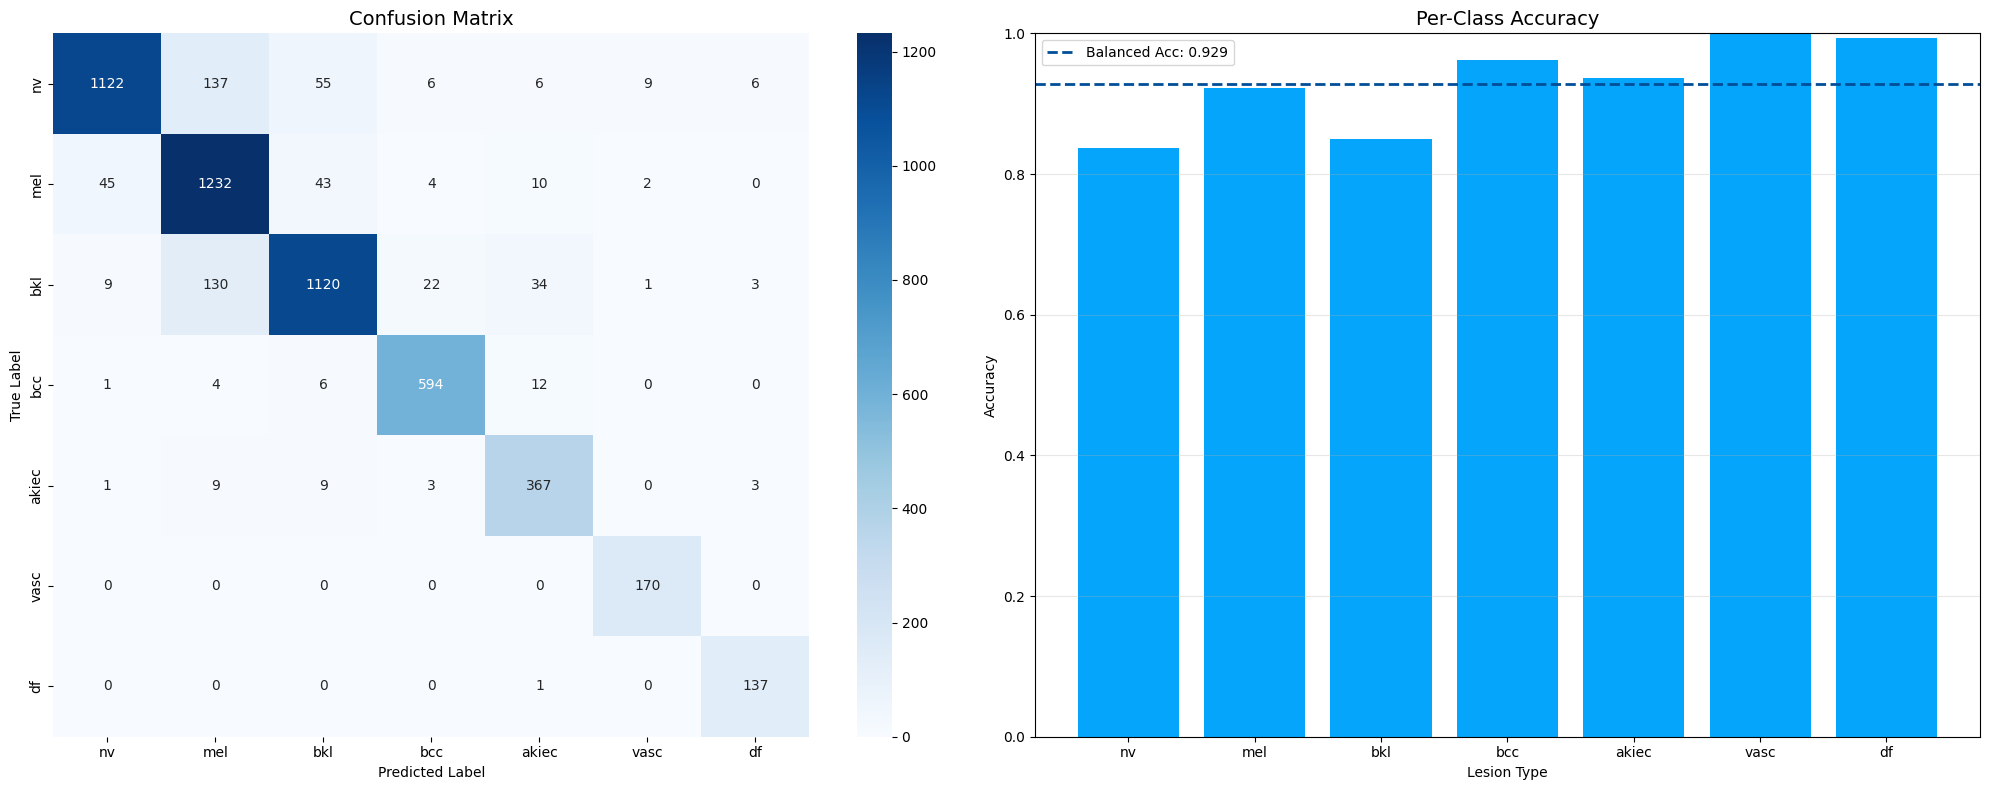

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

lesion_types = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=lesion_types,
    yticklabels=lesion_types,
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='normal')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Per-Class Accuracy
bars = axes[1].bar(
    lesion_types,
    per_class_acc,
    color='#04A5FA',
    alpha=1
)

axes[1].axhline(
    y=vfl4_balanced_acc,
    color='#004E98',
    linestyle='--',
    linewidth=2,
    label=f'Balanced Acc: {vfl4_balanced_acc:.3f}'
)

axes[1].set_xlabel('Lesion Type')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Per-Class Accuracy', fontsize=14, fontweight='normal')
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Compute alignment scores for cross-modal invariant embeddings
inv_img_test_norm = test_inv_img / (np.linalg.norm(test_inv_img, axis=1, keepdims=True) + 1e-8)
inv_tab_test_norm = test_inv_tab / (np.linalg.norm(test_inv_tab, axis=1, keepdims=True) + 1e-8)

alignment_scores = np.sum(inv_img_test_norm * inv_tab_test_norm, axis=1)
avg_alignment = np.mean(alignment_scores)

exp4_results = {
    'test_accuracy': float(vfl4_test_acc),
    'balanced_accuracy': float(vfl4_balanced_acc),
    'confusion_matrix': cm,
    'training_history': {
        'loss': vfl4_train_loss_history,
        'acc': vfl4_train_acc_history,
        'val_loss': vfl4_val_loss_history,
        'val_acc': vfl4_val_acc_history,
        'class_loss': vfl4_class_loss_history,
        'align_loss': vfl4_align_loss_history,
        'comm_upload': vfl4_comm_costs_upload,
        'comm_download': vfl4_comm_costs_download
    },
    'per_class_accuracy': per_class_acc.tolist(),
    'predictions': y_pred,
    'alignment_stats': {
        'mean': float(avg_alignment),
        'min': float(alignment_scores.min()),
        'max': float(alignment_scores.max()),
        'std': float(alignment_scores.std())
    },
    'hyperparameters': {
        'lambda_alignment': LAMBDA_ALIGNMENT,
        'num_heads': 4,
        'key_dim': 32
    },
    'training_time_minutes': vfl4_total_time / 60,
    'architecture': 'cross_modal_transformer'
}

with open(get_save_path('final_results'), 'wb') as f:
    pickle.dump(exp4_results, f)

print("Results saved successfully")

Results saved successfully


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Next Steps</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

This foundation notebook has established the baseline Hybrid VFL model, computed embeddings, and performance metrics. To explore adversarial attacks and security analysis, proceed to the following notebooks:

* **[INTEGRITY AUDIT](https://www.kaggle.com/code/mostafaanoosha/dharma-02-integrity-audit)** - Evaluates untargeted noise attacks, targeted label-flipping attacks, backdoor attacks, and WaveAttack
* **[PRIVACY AUDIT](https://www.kaggle.com/code/mostafaanoosha/dharma-03-privacy-audit)** - Analyzes label inference attacks, membership inference attacks, and data reconstruction attacks